In [1]:
# <img src="../images/sberbank.png">
# <center> Лабораторная 3 </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt
import lightgbm
from statistics import mean

from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

C:\Users\darya\AppData\Local\Temp/ipykernel_13596/3982866499.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [3]:
# Считываем данные
tr_mcc_codes = pd.read_csv('data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

del transactions

In [4]:
tr_mcc_codes.head()

,mcc_description
mcc_code,
742,Ветеринарные услуги
1711,"Генеральные подрядчики по вентиляции, теплосна..."
1731,Подрядчики по электричеству
1799,"Подрядчики, специализированная торговля — нигд..."
2741,Разнообразные издательства/печатное дело


In [5]:
def argmax(d):
    max_value = -1
    i = -1
    for index in range(len(d)):
        if d[index] > max_value:
            max_value = d[index]
            i = index
    return i

In [6]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=lightgbm.cv(params, lightgbm.Dataset(train, y_true), early_stopping_rounds=10, 
                       num_boost_round=100, nfold=5, stratified=True, metrics=['auc'])
    mean_auc = argmax(cv_res['auc-mean'])
    mean_std = argmax(cv_res['auc-stdv'])
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res['auc-mean'][mean_auc], cv_res['auc-stdv'][mean_std], mean_auc))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = lightgbm.train(params, lightgbm.Dataset(train.values, target, feature_name=list(train.columns)), 
                    num_boost_round=num_trees)
    y_pred = clf.predict(test.values)
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    print(clf.feature_importance())
    feature_names = clf.feature_name()
    importances = dict(sorted(zip(feature_names, clf.feature_importance()), key=lambda x: x[1]))
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances), align='center', color='green')
    plt.yticks(y_pos, feature_names, fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели (не забывайте, что с этим Вы можете тоже экспериментировать).

In [7]:
params = {
    'eta': 0.1,
#     'max_depth': 3,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
    
#     'gamma': 0,
#     'lambda': 0,
#     'alpha': 0,
#     'min_child_weight': 0,
    
    #'eval_metric': 'auc',
#     'objective': 'binary:logistic' ,
#     'booster': 'gblinear',
#     'tree_method': 'approx'
}

In [8]:
tqdm_notebook.pandas(desc="Progress:")

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [9]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [10]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

In [11]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 22899 to 99999680
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   day_0                         8354 non-null   float64
 1   day_1                         8314 non-null   float64
 2   day_2                         8228 non-null   float64
 3   day_3                         8348 non-null   float64
 4   day_4                         8360 non-null   float64
 5   day_5                         8364 non-null   float64
 6   day_6                         8348 non-null   float64
 7   hour_0                        6650 non-null   float64
 8   hour_1                        3452 non-null   float64
 9   hour_10                       8195 non-null   float64
 10  hour_11                       8219 non-null   float64
 11  hour_12                       8228 non-null   float64
 12  hour_13                       8205 non-null   float64


In [13]:
gender_train.value_counts()

gender
0         4687
1         3713
dtype: int64

In [14]:
data_train = data_train.join(transactions_train, how='inner')
data_train = data_train.drop(['tr_datetime', 'term_id', 'negative_transactions_median', 'positive_transactions_median', 'gender'], axis=1)
# Не использовались по итогам обучения
data_train = data_train.drop(['tr_type', 'amount', 'day', 'hour', 'night'], axis=1)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3751083 entries, 22899 to 99999680
Data columns (total 44 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   day_0                        float64
 1   day_1                        float64
 2   day_2                        float64
 3   day_3                        float64
 4   day_4                        float64
 5   day_5                        float64
 6   day_6                        float64
 7   hour_0                       float64
 8   hour_1                       float64
 9   hour_10                      float64
 10  hour_11                      float64
 11  hour_12                      float64
 12  hour_13                      float64
 13  hour_14                      float64
 14  hour_15                      float64
 15  hour_16                      float64
 16  hour_17                      float64
 17  hour_18                      float64
 18  hour_19                      float64


In [15]:
data_test = data_test.join(transactions_test, how='inner')
data_test = data_test.drop(['tr_datetime', 'term_id', 'negative_transactions_median', 'positive_transactions_median'], axis=1)
data_test = data_test.drop(['tr_type', 'amount', 'day', 'hour', 'night'], axis=1)

In [16]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642254 entries, 6815 to 99991245
Data columns (total 44 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   day_0                        1641952 non-null  float64
 1   day_1                        1641374 non-null  float64
 2   day_2                        1639880 non-null  float64
 3   day_3                        1641952 non-null  float64
 4   day_4                        1641965 non-null  float64
 5   day_5                        1642034 non-null  float64
 6   day_6                        1641885 non-null  float64
 7   hour_0                       1492535 non-null  float64
 8   hour_1                       940071 non-null   float64
 9   hour_10                      1639020 non-null  float64
 10  hour_11                      1638833 non-null  float64
 11  hour_12                      1639201 non-null  float64
 12  hour_13                      1638731 n

In [17]:
target = data_train.join(gender_train, how='inner')['gender']

cv_score(params, data_train, target)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 3000866, number of used features: 44
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 3000866, number of used features: 44
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 3000866, number of used 

In [18]:
clf, submission = fit_predict(params, 99, data_train, data_test, target)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11076
[LightGBM] [Info] Number of data points in the train set: 3751083, number of used features: 44
[LightGBM] [Info] Start training from score 0.476900


[ 60  65  76  64  62  67  62  80  75  71  71  55  79  71  70  66  77  77
  62  71  88  66  78  73  51  65  86  85  91  82  61 107  56  79  46  52
  52   8  87  63  71  63  55  24]


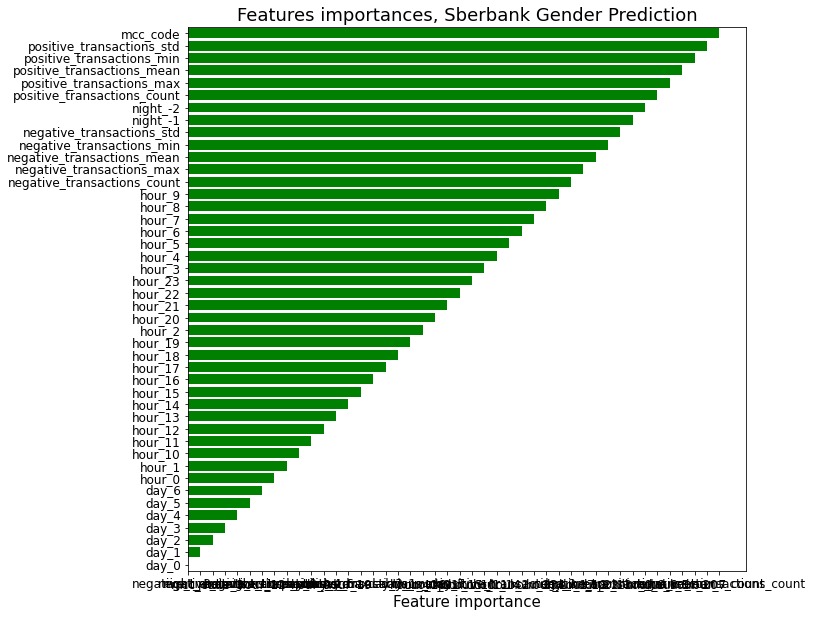

In [19]:
draw_feature_importances(clf, 10)

### Добавление новых переменных улучшило наши результаты ROC AUC с 62.5% до 68.2%, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

# (!) Цель задания:
## Полученная модель должна иметь ROC AUC на Public-части тестовой выборки (на лидерборде) не менее 80%.